# LSTM Models with TensorFlow

In this workshop you'll use Tensorflow to create univariate and multivariate forecasting models.

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

# Some default styles for figures
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False

## Dataset

For this workshop we're going to be using the energy demand dataset for the examples, but please feel free to use any of the other time series datasets (or your own) to work through the workshop content. The target will be the energy usage `demand` in megawatts. 

In [2]:
df = pd.read_csv(
    "datasets/energy/nyc_energy.csv.gz", 
    names=['timestamp', 'demand', 'precip', 'temp'], 
    index_col='timestamp', 
    parse_dates=True, 
    header=0,
)

df.dropna(inplace=True)
df.head()

,demand,precip,temp
timestamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,4275.5,0.0,42.61


In [4]:
def plot_dataset(df=df):
    fig, axes = plt.subplots(len(df.columns), sharex=True)
    for col, ax, c in zip(df.columns, axes, ['C0', 'C1', 'C2']):
        df[col].plot(ax=ax, c=c)
        ax.set_title(col)
        
        if ax != axes[-1]:
            ax.set_xlabel("")
            
            
plot_dataset()

<IPython.core.display.Javascript object>

## Splits

For machine learning purposes we'll split our dataset into 70% training data, 20% validation data and 10% test data. The data cannot be randomly shuffled before splitting since this is time series data! 

In [5]:
n = df.shape[0]

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = df.shape[1]

## Normalization

It is important to scale features before training a neural network because the activation functions are sensitive to large values. Most neural networks expect data to be in the range `[-1, 1]`. Normalization is a common way of scaling, simply subtracting the mean and dividing by the standard deviation. 

Note it is important that we only apply the mean and standard deviation of the **training** data to the models so that the information doesn't leak during validation and testing.

In [6]:
mu = train_df.mean()
std = train_df.std()

train_df = (train_df - mu) / std
val_df = (val_df - mu) / std
test_df = (test_df - mu) / std

<IPython.core.display.Javascript object>


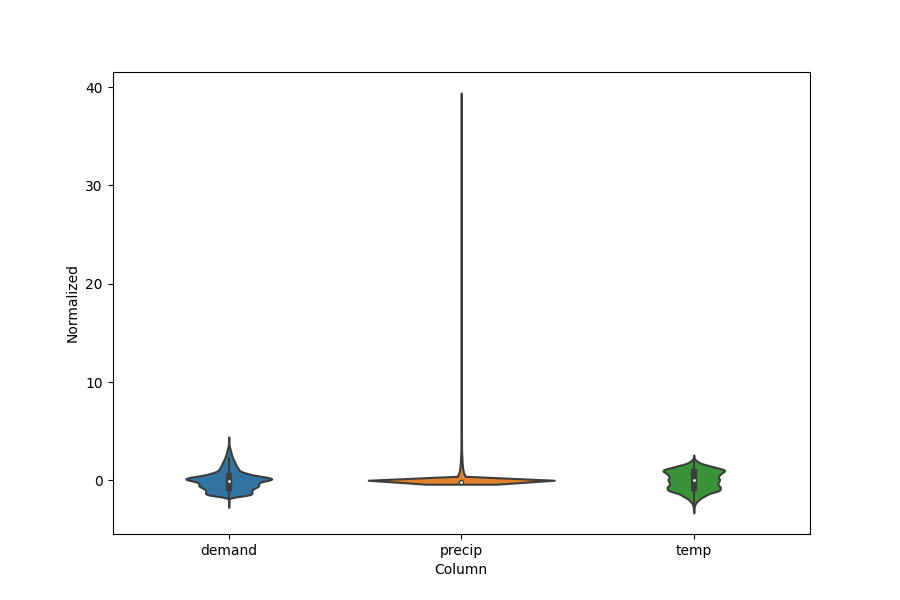

In [7]:
dfnorm = (df - mu) / std
dfnorm = dfnorm.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=dfnorm)

## Data Windowing

LSTM models make predictions based on a window of consecutive samples from the data. The samples (instances) must be created as windows with a `width` - the number of timesteps in each window, the `offset` for a rolling window and which features are used as inputs or labels.

Window selection depends on the type of model and the prediction task.

- To generate a single prediction 24 hours in the future, width=24, offset=24, label_width = 1
- To make a prediction 1 hour in the future given 6 hours of history, width=6, offset=1, label_width=1

> Experiment with different window sizes throughout this workshop!

The TensorFlow tutorial recommends the following window generator, but in practice, you'll likely want to create a windowing method specific to your data.

In [8]:
class WindowGenerator(object):
    
    def __init__(
        self, 
        input_width, 
        label_width, 
        shift,
        column_indices=column_indices,
        label_columns=None
    ):
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }

        self.column_indices = column_indices

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        
        # Slicing doesn't preserve static shape information, so set manually
        # Makes the tf.data.Datasets easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

In [9]:
wins = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['demand'])
wins

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['demand']

The `split_window` method takes input data that the model expect, we can create an example of this by using `tf.stack` to compile three instances with the specified window size, then split the windows into input and label arrays.

In [10]:
# Create a tensor with the 0th, 100th, and 200th windows
example = tf.stack([
    np.array(train_df[:wins.total_window_size]),
    np.array(train_df[100:100+wins.total_window_size]),
    np.array(train_df[200:200+wins.total_window_size]),
])

# Split into inputs and labels
example_inputs, example_labels = wins.split_window(example)

# Describe shapes of datasets
# Note that using TensorFlow is mostly about getting array shapes and dimensions correct!
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
labels shape: (3, 1, 1)


The following function will allow us to visualize window instances, the targets and the model predictions if a model is supplied. We'll use this function later on as well.

**Note** - you could make this function a method of `WindowGenerator` as well, and replace `wins` with `self`.

In [11]:
def plot_windows(wins, inputs, labels, model=None, n_subplots=3, col='demand'):
    # Ensure that we plot the number of subplots or all the data in inputs, labels
    n_subplots = min(n_subplots, len(inputs))
    plot_col_index = wins.column_indices[col]
    
    fig, axes = plt.subplots(n_subplots, 1, figsize=(9, 8), sharex=True)
    for i in range(n_subplots):
        ax = axes[i]
        ax.plot(
            wins.input_indices, inputs[i, :, plot_col_index],
            label="Inputs", marker='.', zorder=-10
        )
        
        if wins.label_columns:
            label_col_index = wins.label_columns_indices.get(col, None)
        else:
            label_col_index = plot_col_index
        
        if label_col_index is None:
            continue
        
        ax.scatter(
            wins.label_indices, labels[i, :, label_col_index],
            edgecolors='k', label='Labels', c='#2ca02c', s=64,
        )
        
        if model is not None:
            preds = model(inputs)
            ax.scatter(
                wins.label_indices, preds[i, :, label_col_index],
                marker='X', edgecolors='k', label="Predictions", c="#ff7f0e", s=64,
            )
        
        ax.set_ylabel(f'{col} [normed]')
        
    axes[0].legend()
    axes[-1].set_xlabel("Hour")
    
    
plot_windows(wins, example_inputs, example_labels)

<IPython.core.display.Javascript object>

## Create Datasets

In order to use TensorFlow, we'll need to convert our dataframes into `tf.data.Dataset` objects of `(input_window, label_window)` pairs. To do this, we'll use the `timeseries_dataset_from_array` function and map the `WindowGenerator.split_window` function to it.

**Note** - you could make this function a method of `WindowGenerator` as well, and replace `wins` with `self`.

In [12]:
def make_dataset(wins, data):
    # Convert data into a numpy array, it's likely its a dataframe
    # this will prevent downstream tensorflow errors
    data = np.array(data, dtype=np.float32)
    
    # Batch size should always be a power of 2 to ensure that
    # GPUs can take full advantage of stride length.
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=wins.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )
    
    ds = ds.map(wins.split_window)
    return ds

In [13]:
train = make_dataset(wins, train_df)
val = make_dataset(wins, val_df)
test = make_dataset(wins, test_df)

In [14]:
# Get the structure, dtypes, and shapes of dataset elements
train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline Model

To compare models, we'll start with a baseline model that predicts "no change", e.g. it predicts the previous value as the next value.

In [16]:
class Baseline(tf.keras.Model):
    
    def __init__(self, label_index=None):
        super(Baseline, self).__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        # Univariate case
        if self.label_index is None:
            return inputs
        
        # Multivariate case
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

We can instantiate and evaluate this model:

In [17]:
baseline = Baseline(label_index=column_indices["demand"])
baseline.compile(
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

# We will track our performance across models
performance = {
    "validation": {},
    "test": {}
}


performance["validation"]['Baseline'] = baseline.evaluate(val)
performance["test"]['Baseline'] = baseline.evaluate(test, verbose=0)

306/306 [==============================] - 0s 1ms/step - loss: 0.4143 - mean_absolute_error: 0.4757


### Visualizing Results

We can get the MSE of the validation and test set from the loss, but it's hard to see what's happening. Instead, we can create a 24 hour window and generate predictions across the wider window for each of the model steps. This will allow us to see how the model is operating across a _sequence of instances_.

We can use our `WindowGenerator` to assist us with this as well.

In [18]:
eval_window = WindowGenerator(
    input_width=36, label_width=36, shift=1, label_columns=['demand']
)

eval_window

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
Label column name(s): ['demand']

<IPython.core.display.Javascript object>


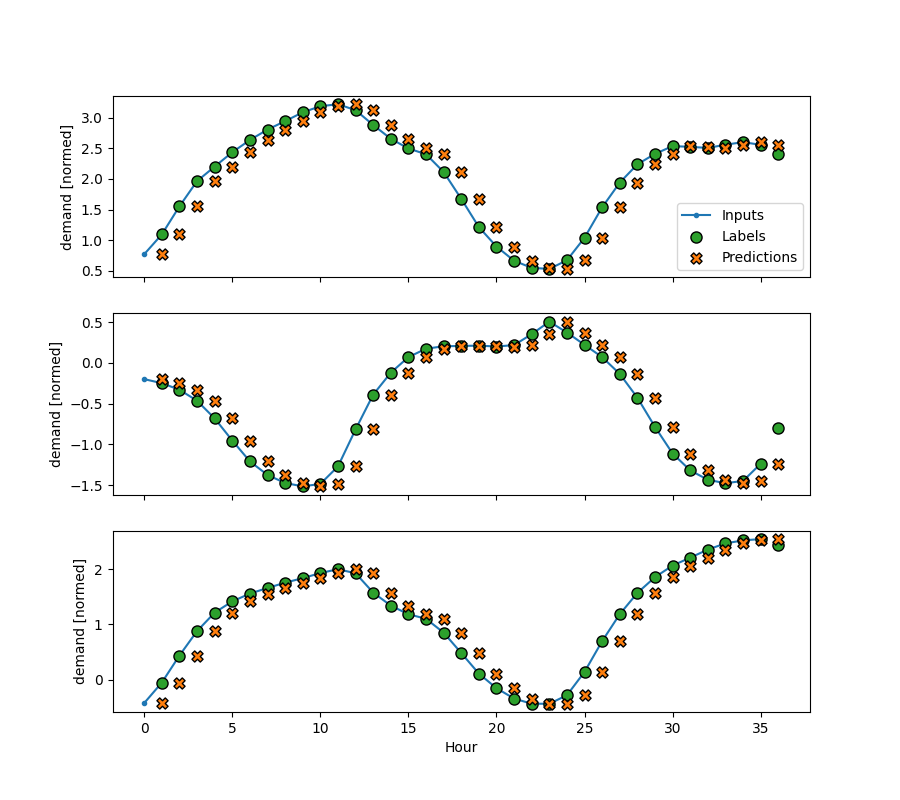

In [36]:
# Get the first batch from the training data for visual evaluation
eval_input, eval_labels = next(iter(make_dataset(eval_window, train_df)))

# Plot the eval windows with the baseline model
plot_windows(eval_window, eval_input, eval_labels, model=baseline)

As you can see, the baseline predictions are just the labels shifted right by 1 hour.

## Training Models

The following helper function will allow us to compile and fit models with the specified window generator.

In [28]:
MAX_EPOCHS = 20 

def fit(model, data=train, val_data=val, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, mode='min'
    )
    
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[
            tf.metrics.MeanAbsoluteError()
        ]
    )
    
    return model.fit(
        data, epochs=MAX_EPOCHS, validation_data=val_data,
        callbacks=[early_stopping]
    )

## Linear Model

A `layers.Dense` with no activation function is a linear model using TensorFlow. The layer transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)` independently applied to every item across the `batch` and `time` axes.

Note that the flatten and reshape layers allow our multi-step input (6 time steps before a single prediction) to work.

In [29]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1),
])

In [30]:
history = fit(linear)
performance["validation"]['Linear'] = linear.evaluate(val)
performance["test"]['Linear'] = linear.evaluate(test, verbose=0)

Epoch 1/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.8279 - mean_absolute_error: 0.6891 - val_loss: 0.4195 - val_mean_absolute_error: 0.5136
Epoch 2/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.4127 - mean_absolute_error: 0.5049 - val_loss: 0.3690 - val_mean_absolute_error: 0.4699
Epoch 3/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.3935 - mean_absolute_error: 0.4857 - val_loss: 0.3692 - val_mean_absolute_error: 0.4683
Epoch 4/20
306/306 [==============================] - 0s 1ms/step - loss: 0.3693 - mean_absolute_error: 0.4684


## Deeper Models

We can deepen the simple linear model by stacking a few `Dense` layers between the input and the output. Because we have a multi-step input, we can add a `Flatten` layer at the beginning and reshape the output to add the time column back in.

In [34]:
dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = fit(dense)

performance["validation"]['Dense'] = dense.evaluate(val)
performance["test"]['Dense'] = dense.evaluate(test, verbose=0)

Epoch 1/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0792 - mean_absolute_error: 0.1648 - val_loss: 0.0183 - val_mean_absolute_error: 0.0999
Epoch 2/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0152 - mean_absolute_error: 0.0883 - val_loss: 0.0149 - val_mean_absolute_error: 0.0866
Epoch 3/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0103 - mean_absolute_error: 0.0730 - val_loss: 0.0090 - val_mean_absolute_error: 0.0666
Epoch 4/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0668 - val_loss: 0.0074 - val_mean_absolute_error: 0.0607
Epoch 5/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0613 - val_loss: 0.0072 - val_mean_absolute_error: 0.0570
Epoch 6/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0581 - val_loss: 0.0064 - val_mean_absolute_error: 0.0538
Epoc

### Convolutional Neural Network

A convolutional layer also takes multiple time steps as input, and allows us to rewrite the above `Dense` model using a convolution. Here we are replacing the `Flatten` and first `Dense` layer with a `Conv1D`, and this means that the `Reshape` layer is no longer necessary because the convolution keeps the time axis in its output.

This has the added advantage that we can run the model on inputs of any length, unlike the `dense` model which required a fixed length input. This is the preferred way to write the deeper model.

In [35]:
conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=6, # same as the width of the input
        activation='relu',
    ),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = fit(conv)

performance["validation"]['Convolutional'] = conv.evaluate(val)
performance["test"]['Convolutional'] = conv.evaluate(test, verbose=0)

Epoch 1/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0470 - mean_absolute_error: 0.1304 - val_loss: 0.0106 - val_mean_absolute_error: 0.0731
Epoch 2/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0683 - val_loss: 0.0079 - val_mean_absolute_error: 0.0590
Epoch 3/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0600 - val_loss: 0.0063 - val_mean_absolute_error: 0.0529
Epoch 4/20
1070/1070 [==============================] - 2s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0554 - val_loss: 0.0071 - val_mean_absolute_error: 0.0562
Epoch 5/20
306/306 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0629


<IPython.core.display.Javascript object>


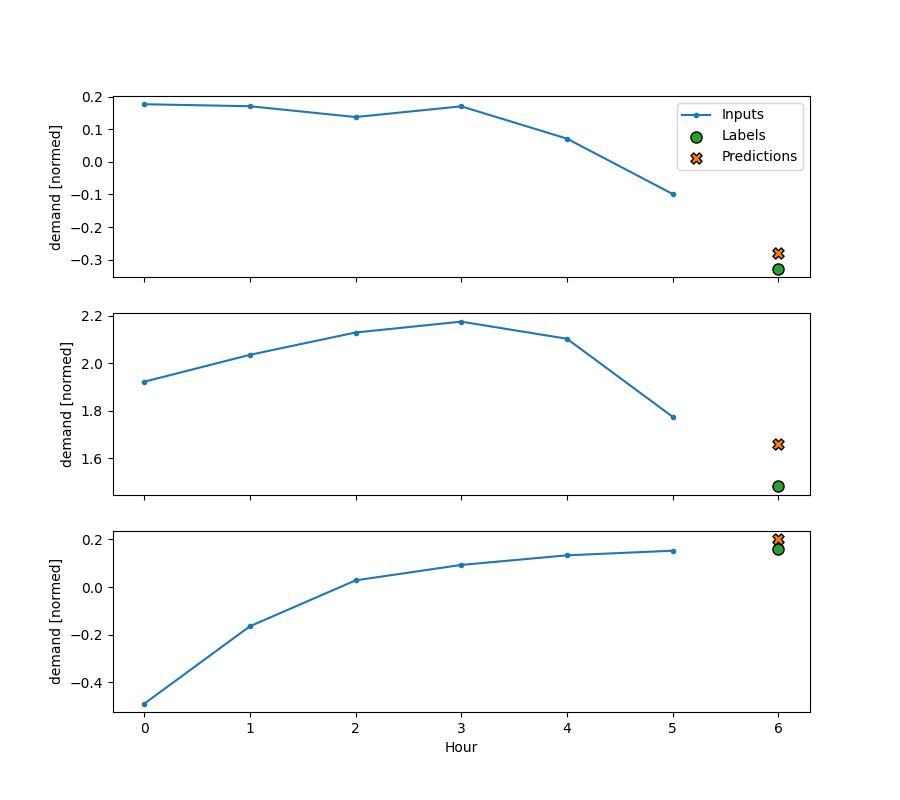

In [41]:
eval_input, eval_labels = next(iter(train))

# Plot the eval windows with the baseline model
plot_windows(wins, eval_input, eval_labels, model=conv)

## LSTMs

At long last we can use the Long Short Term Memory (LSTM) RNN (recurrent neural network). The LSTM processes a time series step-by-step, maintaining an internal step from time-step to time-step. RNNs and LSTMs are therefore very well suited to time series analysis. 

An important constructor argument for keras RNN layers is `return_sequences`:

- if `False`: layer only returns the output of the final timestep, allowing the model to warm up its internal state before prediction.
- if `True`: layer returns an output for each input, used for stacking or training on multiple timesteps simultaneously.

In [42]:
lstm = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = fit(lstm)

performance["validation"]['LSTM'] = lstm.evaluate(val)
performance["test"]['LSTM'] = lstm.evaluate(test, verbose=0)

Epoch 1/20
1070/1070 [==============================] - 5s 4ms/step - loss: 0.0587 - mean_absolute_error: 0.1576 - val_loss: 0.0083 - val_mean_absolute_error: 0.0640
Epoch 2/20
1070/1070 [==============================] - 4s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0585 - val_loss: 0.0065 - val_mean_absolute_error: 0.0512
Epoch 3/20
1070/1070 [==============================] - 4s 4ms/step - loss: 0.0051 - mean_absolute_error: 0.0522 - val_loss: 0.0070 - val_mean_absolute_error: 0.0535
Epoch 4/20
306/306 [==============================] - 1s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0532


## Performance

Let's plot the performance of our models and see how each did:

<IPython.core.display.Javascript object>


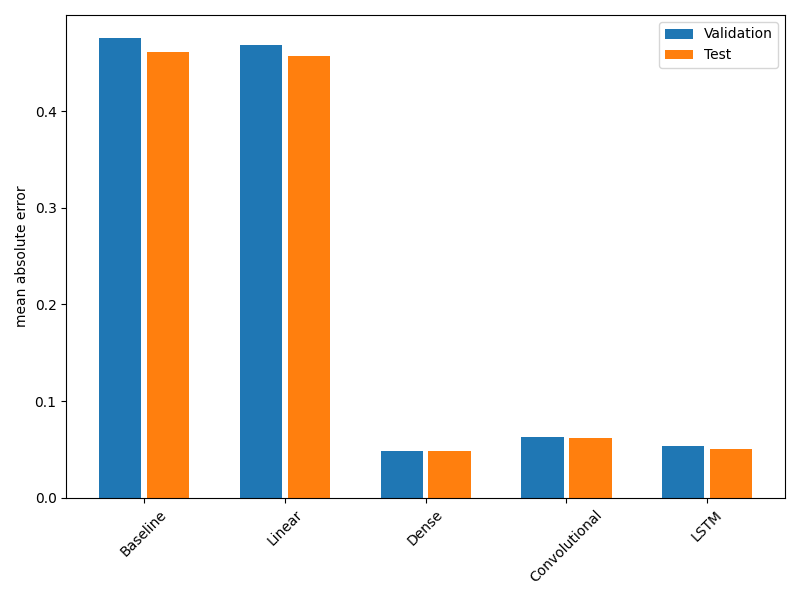

In [49]:
def plot_performance(data=performance, metric=1):
    x = np.arange(len(data['test']))
    width = 0.3
    
    # NOTE: metric=0 is MSE and metric=1 is MAE
    val = [v[metric] for v in data['validation'].values()]
    tst = [v[metric] for v in data['test'].values()]
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(x-0.17, val, width, label='Validation')
    ax.bar(x+0.17, tst, width, label='Test')
    
    ax.set_xticks(x)
    ax.set_xticklabels(data['test'].keys(), rotation=45)
    ax.legend()
    
    metric = "mean absolute error" if metric == 1 else "mean squared error"
    ax.set_ylabel(metric)
    
    fig.tight_layout()
    return ax


_ = plot_performance()